# Singular value decomposition for image processing

In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os

import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

from sklearn.datasets import fetch_olivetti_faces

import gdown

## Data

In [3]:
!rm -rf yale_face
!rm -rf img_align_celeba
gdown.download("https://drive.google.com/uc?id=1AwKHDT4W9vs6TQNCsebHjwa7QKCbpsPZ", "yale_face.zip")
gdown.download("https://drive.google.com/uc?id=1Bi6UsHMUmd4iqCwVWlKeLgf4HgT9PMfr", "celeba.zip")
!unzip -q yale_face.zip
!unzip -q celeba.zip
!mv img_align_celeba celeba

Downloading...
From: https://drive.google.com/uc?id=1AwKHDT4W9vs6TQNCsebHjwa7QKCbpsPZ
To: /content/yale_face.zip
100%|██████████| 55.7M/55.7M [00:00<00:00, 122MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Bi6UsHMUmd4iqCwVWlKeLgf4HgT9PMfr
To: /content/celeba.zip
100%|██████████| 1.44G/1.44G [00:24<00:00, 59.3MB/s]


In [4]:
data_type = "celeba"  # yale, celeba

if data_type == "yale":
    root = "./yale_face"
    files = sorted(os.listdir(root))
    files_test = None
    shape = (48, 42)  # Size can be changed, e.g., (96, 84) or (192, 168)
elif data_type == "celeba":
    root = "./celeba"
    files = sorted(os.listdir(root))
    files_test = files[10000:11000]
    files = files[:10000]
    shape = (54, 44)

images = []
for file in tqdm(files):
    image = Image.open(f"{root}/{file}")
    image = image.resize(shape[::-1])
    image = np.asarray(image).astype(np.float32) / 255
    images.append(image)
images = np.stack(images, axis=0)
num_images = images.shape[0]
image_shape = images.shape[1:]
print(f"We have {num_images} of shape {image_shape}.")

if files_test is not None:
    images_test = []
    for file in tqdm(files_test):
        image = Image.open(f"{root}/{file}")
        image = image.resize(shape[::-1])
        image = np.asarray(image).astype(np.float32) / 255
        images_test.append(image)
    images_test = np.stack(images_test, axis=0)
    num_images_test = images_test.shape[0]
    print(f"We have (test) {num_images_test} of shape {image_shape}.")
else:
    images_test = None

  0%|          | 0/10000 [00:00<?, ?it/s]

We have 10000 of shape (54, 44, 3).


  0%|          | 0/1000 [00:00<?, ?it/s]

We have (test) 1000 of shape (54, 44, 3).


In [5]:
def imshow(image, shape=image_shape, vmin=0, vmax=1, dpi=72, cmap="gray"):
    plt.figure(dpi=dpi)
    plt.axis("off")
    if shape is not None:
        image = np.reshape(image, shape)
    if vmin is None:
        vmin = image.min()
    if vmax is None:
        vmax = image.max()
    plt.imshow(image, vmin=vmin, vmax=vmax, cmap=cmap)

In [6]:
def imshow_sequence(images, normalize=False, shape=image_shape, idxs=None, sort=True, title=True,
                    dpi=72, **kwargs):
    if type(images) in (tuple, list):
        images = np.stack(images, axis=0)
    if type(idxs) == int:
        idxs = np.random.choice(len(images), idxs)
        if sort:
            idxs.sort()
    elif idxs is None:
        idxs = list(range(len(images)))
    images_show = images[idxs]

    fig, axs = plt.subplots(1, len(images_show), figsize=(20, 20), dpi=dpi)
    for i in tqdm(range(images_show.shape[0])):
        image = images_show[i]
        if shape is not None:
            image = np.reshape(image, shape)
        if type(title) in (tuple, list):
            axs[i].title.set_text(title[i])
        elif title:
            axs[i].title.set_text(f"$i = {idxs[i]}$")
        axs[i].axis("off")
        if normalize:
            image = (image - image.min()) / (image.max() - image.min())
        axs[i].imshow(image, **kwargs)

## Singular value decomposition

In [7]:
D = np.reshape(images, (images.shape[0], -1)).T
print(f"We flatten the images to {D.shape[0]}-dimensional vectors. "
      "They are now column vectors of D.")

if images_test is not None:
    D_test = np.reshape(images_test, (images_test.shape[0], -1)).T

We flatten the images to 7128-dimensional vectors. They are now column vectors of D.


In [8]:
D_mean = np.mean(D, axis=1)[:, None]
D_tilde = D - D_mean  # Mean-center D

The singular value decomposition (SVD) decomposes our dataset $\boldsymbol{D}$ (or more precisely, the mean-centered $\tilde{\boldsymbol{D}}$), into
$$ \boldsymbol{D} = \boldsymbol{U} \boldsymbol{\Sigma} \boldsymbol{V}^T . $$
Particularly, $\boldsymbol{D} \in \mathbb{R}^{d \times n}$, where $d$ is dimensions (i.e., number of pixels) in one image and $n$ is the number of images, so the images are column vectors of $\boldsymbol{D}$. We are primarily interested in $\boldsymbol{U} \in \mathbb{R}^{d \times d}$, as the column vectors of $\boldsymbol{U}$ are the eigenfaces of $\boldsymbol{D}$ in order of decreasing singular values, i.e., importance.

In [9]:
%%time

U, S, VT = linalg.svd(D_tilde)  # Can take a while

CPU times: user 13min 6s, sys: 37.1 s, total: 13min 43s
Wall time: 8min 8s


In [10]:
# The column vectors of U is our collection of eigenfaces. We reshape U into U_show so U_show can be
# directly displayed as the eigenfaces.
U_show = np.reshape(U.T, (U.shape[0],) + image_shape)
V = VT.T  # Technically SVD actually outputs V^T, so we transpose it back here

In [11]:
print(f"Results of SVD: U is {U.shape}, S is {S.shape}, and V is {V.shape}")

Results of SVD: U is (7128, 7128), S is (7128,), and V is (10000, 10000)


## Projection & Reconstruction

In [12]:
def extract_from_D(D, i, column=True):
    """Extracts the i^th column vector from D, column=True keeps it as a column vector."""
    if column:
        x = D[:, i:i + 1]
    else:
        x = D[:, i]
    return x

In [13]:
def projection(x, U):
    """Projects x into the column space of U, i.e., write x as linear combination of U."""
    if len(x.shape) == 1:  # Make x a column vector
        x = np.expand_dims(x, axis=1)
    x = x - D_mean
    # We are leaving the left-mulplication of linalg.inv(U.T @ U) since U is orthogonal and thus
    # U^T U = I, and the inverse of I is still I
    a = U.T @ x
    return a

In [14]:
def reconstruction(a, U):
    """Given the coefficients a, reconstruct x with the column vectors of U."""
    if len(a.shape) == 1:  # Make a a column vector
        a = np.expand_dims(a, axis=1)
    x_hat = U @ a
    x_hat = x_hat + D_mean
    return x_hat

# Facial Feature Reconstruction


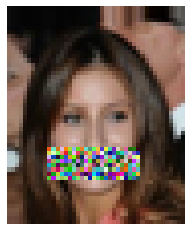

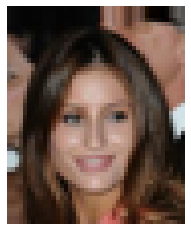

In [15]:
from sys import ps1
def blind_box(img1,img2,top,bot,left,right):
  p1 = np.copy(img1)
  p2 = np.copy(img2)
  for i in range(top,bot):
    for j in range(left,right):
      p1[i,j] = p2[i,j]
  return p1

# top, bot, left, right = 22, 33 , 10, 33
top, bot, left, right = 35, 43 , 10, 33
eye1_top, eye1_bot, eye1_left, eye1_right = 24,32,10,19
eye2_top, eye2_bot, eye2_left, eye2_right = 24,32,24,32
mouth_top, mouth_bot, mouth_left, mouth_right = 36,42,12,32
nose_top, nose_bot, nose_left, nose_right = 24,35,19,24


# img = blind_box(images_test[377], images_test[540], eye1_top, eye1_bot, eye1_left, eye1_right)  
# img = blind_box(img, images_test[21], eye2_top, eye2_bot, eye2_left, eye2_right)  
# img = blind_box(img, images_test[212], mouth_top, mouth_bot, mouth_left, mouth_right)  
# img = blind_box(img, images_test[753], nose_top, nose_bot, nose_left, nose_right)  

half_top, half_bot, half_left, half_right = 0,54,0,22
img = blind_box(images_test[853], images_test[391], 0, 54, 0, 22)  
img = blind_box(images_test[643], images_test[357], 0, 54, 0, 22)  
img = blind_box(img, images_test[634], 28, 54, 0, 22)  
img = blind_box(img, images_test[357], 28, 54, 22, 44)  


img = blind_box(images_test[18], np.random.rand(*image_shape), top, bot, left, right)  # images[87]
# img = blind_box(images_test[18], images_test[817], top, bot, left, right)  # images[87]
# img = images_test[18] + 0.1 * np.random.randn(*images_test[18].shape)
imshow(img)
imshow(images_test[18])
# imshow(images_test[853])

    

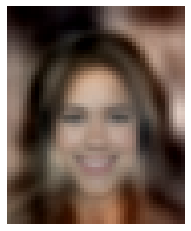

In [16]:
img_vector = np.reshape(img, [-1, 1])
img_coefficients = projection(img_vector, U)
img_coefficients[150:] = 0.0
img_reconstructed = reconstruction(img_coefficients, U)
imshow(img_reconstructed)

  0%|          | 0/9 [00:00<?, ?it/s]

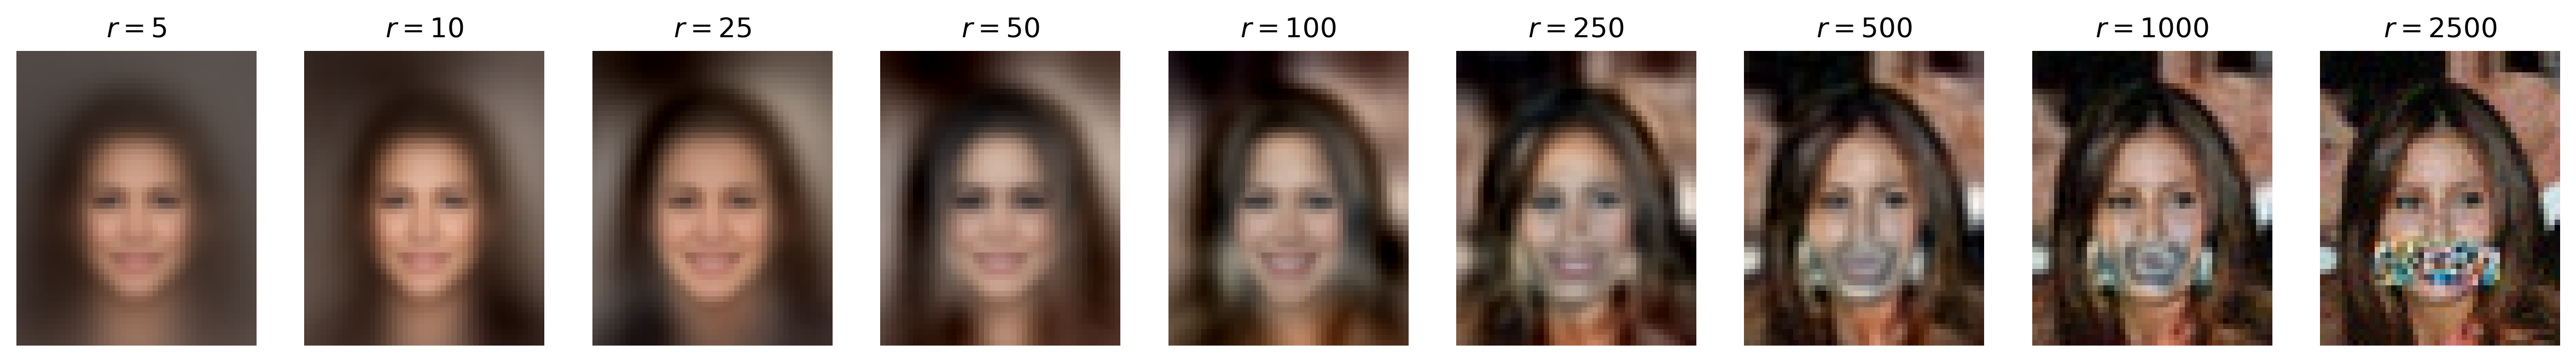

In [17]:
img_coefficients = projection(img_vector, U)
x_reconstructed = []
title = []
for r in [5, 10, 25, 50, 100, 250, 500, 1000, 2500]:
    x_coefficients_compressed = np.copy(img_coefficients)
    x_coefficients_compressed[r:] = 0.0
    x_reconstructed.append(reconstruction(x_coefficients_compressed, U))
    title.append(f"$r = {r}$")

imshow_sequence(x_reconstructed, title=title,
                cmap=None, dpi=300)